## GAP-TV for Video Compressive Sensing
### GAP-TV
> X. Yuan, "Generalized alternating projection based total variation minimization for compressive sensing," in *IEEE International Conference on Image Processing (ICIP)*, 2016, pp. 2539-2543.
### Code credit
[Xin Yuan](https://www.bell-labs.com/usr/x.yuan "Dr. Xin Yuan, Bell Labs"), [Bell Labs](https://www.bell-labs.com/), xyuan@bell-labs.com, created Aug 7, 2018.  
[Yang Liu](https://liuyang12.github.io "Yang Liu, Tsinghua University"), [Tsinghua University](http://www.tsinghua.edu.cn/publish/thu2018en/index.html), y-liu16@mails.tsinghua.edu.cn, updated Jan 20, 2019.

In [1]:
import skimage

In [2]:
skimage.__version__

'0.25.2'

In [3]:
import os
import time
import math
import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from statistics import mean

%matplotlib inline
%load_ext autoreload
%autoreload 2

from pnp_sci_algo import admmdenoise_cacti

from utils import (A_, At_)

In [4]:
# [0] environment configuration
datasetdir = './dataset/cacti' # dataset
# datasetdir = '../gapDenoise/dataset/cacti' # dataset
resultsdir = './results' # results

datname = 'kobe32'        # name of the dataset
# datname = 'traffic48'     # name of the dataset
# datname = 'runner40'      # name of the dataset
# datname = 'drop40'        # name of the dataset
# datname = 'crash32'       # name of the dataset
# datname = 'aerial32'      # name of the dataset
# datname = 'bicycle24'     # name of the dataset
# datname = 'starfish48'    # name of the dataset

# datname = 'starfish_c16_48'    # name of the dataset

matfile = datasetdir + '/' + datname + '_cacti.mat' # path of the .mat data file

In [57]:
import scipy.io as sio
import h5py
import numpy as np

def load_mat_data(matfile):
    try:
        # Try loading the file as a v7.2 (or earlier) MAT-file
        file = sio.loadmat(matfile)
        meas = np.float32(file['meas'])
        mask = np.float32(file['mask'])
        orig = np.float32(file['orig'])
    except NotImplementedError:
        # If the file is v7.3, load it using h5py
        file = h5py.File(matfile, 'r')  # Open the file in read-only mode
        # Switch to MATLAB array order by transposing
        meas = np.float32(file['meas'][:]).transpose()  # Read the dataset and transpose
        mask = np.float32(file['mask'][:]).transpose()
        orig = np.float32(file['orig'][:]).transpose()

    return meas, mask, orig

matfile = "dataset/simdata/drop.mat"
meas, mask, orig = load_mat_data(matfile)


In [58]:
orig.shape

(256, 256, 40)

In [59]:
iframe = 0
nframe = 1
# nframe = meas.shape[2]
MAXB = 255.

# common parameters and pre-calculation for PnP
# define forward model and its transpose
A  = lambda x :  A_(x, mask) # forward model function handle
At = lambda y : At_(y, mask) # transpose of forward model

mask_sum = np.sum(mask, axis=2)
mask_sum[mask_sum==0] = 1

In [60]:
## [2.3] GAP/ADMM-TV
### [2.3.1] GAP-TV
projmeth = 'gap' # projection method
_lambda = 1 # regularization factor
accelerate = True # enable accelerated version of GAP
denoiser = 'tv' # total variation (TV)
iter_max = 40 # maximum number of iterations
tv_weight = 0.3 # TV denoising weight (larger for smoother but slower)
tv_iter_max = 5 # TV denoising maximum number of iterations each

vgaptv,tgaptv,psnr_gaptv,ssim_gaptv,psnrall_gaptv = admmdenoise_cacti(meas, mask, A, At,
                                          projmeth=projmeth, v0=None, orig=orig,
                                          iframe=iframe, nframe=nframe,
                                          MAXB=MAXB, maskdirection='plain',
                                          _lambda=_lambda, accelerate=accelerate,
                                          denoiser=denoiser, iter_max=iter_max, 
                                          tv_weight=tv_weight, 
                                          tv_iter_max=tv_iter_max)

print('{}-{} PSNR {:2.2f} dB, SSIM {:.4f}, running time {:.1f} seconds.'.format(
    projmeth.upper(), denoiser.upper(), mean(psnr_gaptv), mean(ssim_gaptv), tgaptv))

GAP-TV Reconstruction coded frame block  1 of  1 ...
  GAP-TV iteration   5, PSNR 15.56 dB.
  GAP-TV iteration  10, PSNR 29.96 dB.
  GAP-TV iteration  15, PSNR 33.51 dB.
  GAP-TV iteration  20, PSNR 34.44 dB.
  GAP-TV iteration  25, PSNR 34.80 dB.
  GAP-TV iteration  30, PSNR 34.91 dB.
  GAP-TV iteration  35, PSNR 34.96 dB.
  GAP-TV iteration  40, PSNR 34.98 dB.
GAP-TV PSNR 35.20 dB, SSIM 0.9711, running time 6.1 seconds.


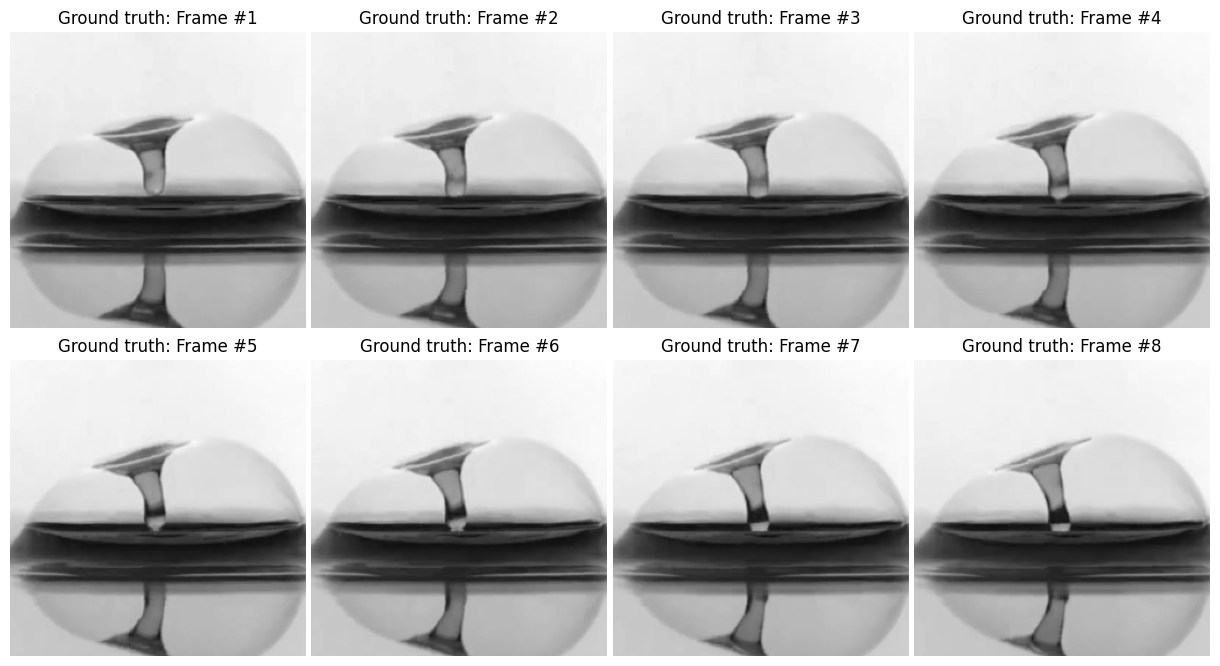

Mean PSNR 35.20 dB.


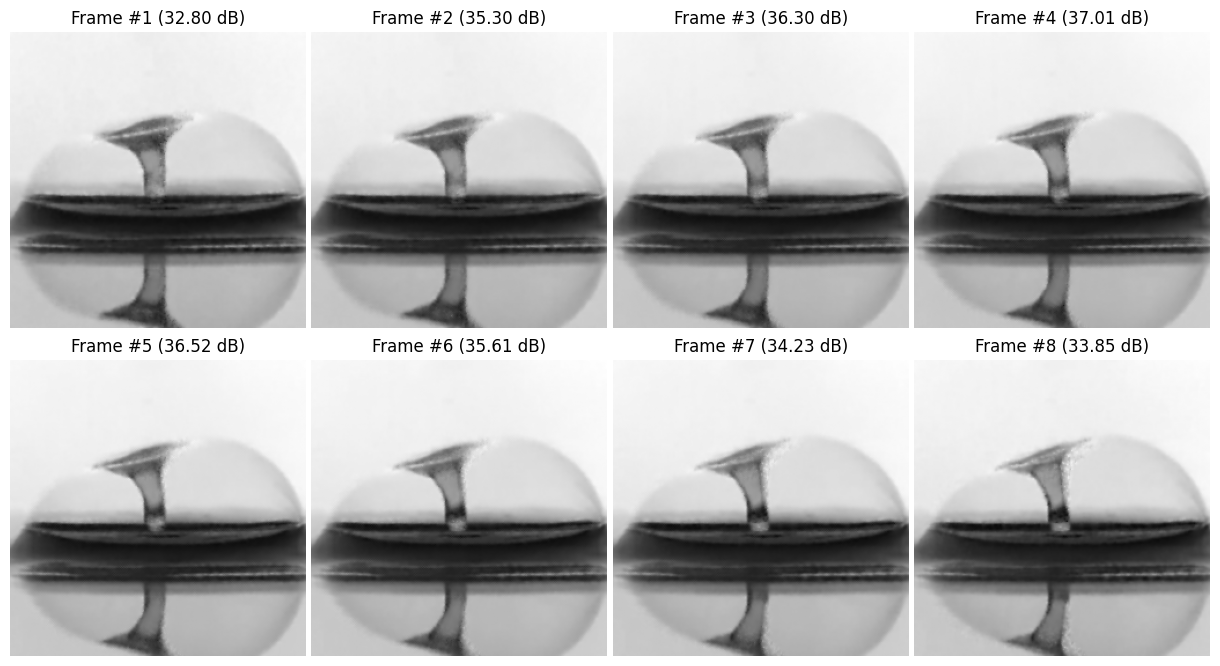

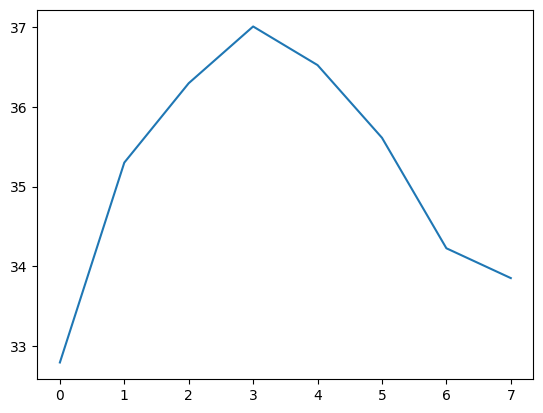

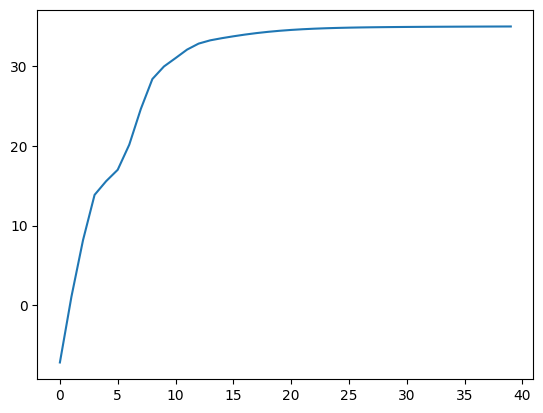

In [61]:
# [3.3] result demonstration of GAP-Denoise
vgapdenoise = vgaptv
psnr_gapdenoise = psnr_gaptv
psnrall_gapdenoise = psnrall_gaptv[0]

nmask = mask.shape[2]

fig = plt.figure(figsize=(12, 6.5))
for nt in range(nmask):
    plt.subplot(nmask//4, 4, nt+1)
    plt.imshow(orig[:,:,nt]/MAXB, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Ground truth: Frame #{0:d}'.format(nt+1), fontsize=12)
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   

fig = plt.figure(figsize=(12, 6.5))
PSNR_rec = np.zeros(nmask)
for nt in range(nmask):
    plt.subplot(nmask//4, 4, nt+1)
    plt.imshow(vgapdenoise[:,:,nt], cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Frame #{0:d} ({1:2.2f} dB)'.format(nt+1,psnr_gapdenoise[nt]), fontsize=12)
    
print('Mean PSNR {:2.2f} dB.'.format(mean(psnr_gapdenoise)))
# plt.title('GAP-{} mean PSNR {:2.2f} dB'.format(denoiser.upper(),np.mean(PSNR_rec)))
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   


plt.figure(2)
# plt.rcParams["font.family"] = 'monospace'
# plt.rcParams["font.size"] = "20"
plt.plot(psnr_gapdenoise)
# plt.plot(psnr_gapdenoise,color='black')
# plt.savefig('./results/savedfig/psnr_framewise_traffic48.png')
plt.show()


plt.figure(3)
plt.plot(psnrall_gapdenoise)
plt.show()




In [63]:
### [2.3.2] ADMM-TV
projmeth = 'admm' # projection method
_lambda = 1 # regularization factor
gamma = 0.01 # parameter in ADMM projection (greater for more noisy data)
denoiser = 'tv' # total variation (TV)
iter_max = 40 # maximum number of iterations
tv_weight = 0.3 # TV denoising weight (larger for smoother but slower)
tv_iter_max = 5 # TV denoising maximum number of iterations each

vadmmtv,tadmmtv,psnr_admmtv,ssim_admmtv,psnrall_admmtv = admmdenoise_cacti(meas, mask, A, At,
                                          projmeth=projmeth, v0=None, orig=orig,
                                          iframe=iframe, nframe=nframe,
                                          MAXB=MAXB, maskdirection='plain',
                                          _lambda=_lambda, gamma=gamma,
                                          denoiser=denoiser, iter_max=iter_max, 
                                          tv_weight=tv_weight, 
                                          tv_iter_max=tv_iter_max)

print('{}-{} PSNR {:2.2f} dB, SSIM {:.4f}, running time {:.1f} seconds.'.format(
    projmeth.upper(), denoiser.upper(), mean(psnr_admmtv), mean(ssim_admmtv), tadmmtv))

c:\Users\makkadir\Desktop\PnP_SCI\python\pnp_sci_algo.py:24: SyntaxWarning: invalid escape sequence '\e'
  '''
c:\Users\makkadir\Desktop\PnP_SCI\python\pnp_sci_algo.py:271: SyntaxWarning: invalid escape sequence '\e'
  X_orig=None, model=None, show_iqa=True):
c:\Users\makkadir\Desktop\PnP_SCI\python\pnp_sci_algo.py:538: SyntaxWarning: invalid escape sequence '\e'
  tv_weight=0.1, tv_iter_max=5, multichannel=True, x0=None,


ADMM-TV Reconstruction coded frame block  1 of  1 ...
  ADMM-TV iteration   5, PSNR  18.90 dB.
  ADMM-TV iteration  10, PSNR  32.26 dB.
  ADMM-TV iteration  15, PSNR  34.27 dB.
  ADMM-TV iteration  20, PSNR  34.75 dB.
  ADMM-TV iteration  25, PSNR  34.87 dB.
  ADMM-TV iteration  30, PSNR  34.91 dB.
  ADMM-TV iteration  35, PSNR  34.93 dB.
  ADMM-TV iteration  40, PSNR  34.95 dB.
ADMM-TV PSNR 35.17 dB, SSIM 0.9714, running time 5.7 seconds.


In [ ]:
import torch
from packages.ffdnet.models import FFDNet

## [2.5] GAP/ADMM-FFDNet
### [2.5.1] GAP-FFDNet (FFDNet-based frame-wise video denoising)
projmeth = 'gap' # projection method
_lambda = 1 # regularization factor
accelerate = True # enable accelerated version of GAPs
denoiser = 'ffdnet' # video non-local network 
noise_estimate = False # disable noise estimation for GAP
sigma    = [50/255, 25/255, 12/255, 6/255] # pre-set noise standard deviation
iter_max = [10, 10, 10, 10] # maximum number of iterations
# sigma    = [12/255, 6/255] # pre-set noise standard deviation
# iter_max = [10,10] # maximum number of iterations
useGPU = True # use GPU

# pre-load the model for FFDNet image denoising
in_ch = 1
model_fn = 'packages/ffdnet/models/net_gray.pth'
# Absolute path to model file
# model_fn = os.path.join(os.path.abspath(os.path.dirname(__file__)), model_fn)

# Create model
net = FFDNet(num_input_channels=in_ch)
# Load saved weights
if useGPU:
    state_dict = torch.load(model_fn)
    device_ids = [0]
    model = torch.nn.DataParallel(net, device_ids=device_ids).cuda()
else:
    state_dict = torch.load(model_fn, map_location='cpu')
    # CPU mode: remove the DataParallel wrapper
    state_dict = remove_dataparallel_wrapper(state_dict)
    model = net
model.load_state_dict(state_dict)
model.eval() # evaluation mode

vgapffdnet,tgapffdnet,psnr_gapffdnet,ssim_gapffdnet,psnrall_gapffdnet = admmdenoise_cacti(meas, mask, A, At,
                                          projmeth=projmeth, v0=None, orig=orig,
                                          iframe=iframe, nframe=nframe,
                                          MAXB=MAXB, maskdirection='plain',
                                          _lambda=_lambda, accelerate=accelerate,
                                          denoiser=denoiser, model=model, 
                                          iter_max=iter_max, sigma=sigma)

print('{}-{} PSNR {:2.2f} dB, SSIM {:.4f}, running time {:.1f} seconds.'.format(
    projmeth.upper(), denoiser.upper(), mean(psnr_gapffdnet), mean(ssim_gapffdnet), tgapffdnet))

UnpicklingError: invalid load key, 'v'.

In [7]:
import torch
from packages.fastdvdnet.models import FastDVDnet

## [2.2] GAP-FastDVDnet
projmeth = 'gap' # projection method
_lambda = 1 # regularization factor
accelerate = True # enable accelerated version of GAP
denoiser = 'fastdvdnet' # video non-local network 
noise_estimate = False # disable noise estimation for GAP
sigma    = [100/255, 50/255, 25/255, 12/255] # pre-set noise standard deviation
iter_max = [20, 20, 20, 20] # maximum number of iterations
# sigma    = [12/255] # pre-set noise standard deviation
# iter_max = [20] # maximum number of iterations
useGPU = True # use GPU

# pre-load the model for fastdvdnet image denoising
NUM_IN_FR_EXT = 5 # temporal size of patch
model = FastDVDnet(num_input_frames=NUM_IN_FR_EXT,num_color_channels=1)

# Load saved weights
state_temp_dict = torch.load('./packages/fastdvdnet/model_gray.pth')
if useGPU:
    device_ids = [0]
    # model = torch.nn.DataParallel(model, device_ids=device_ids).cuda()
    model = model.cuda()
# else:
    # # CPU mode: remove the DataParallel wrapper
    # state_temp_dict = remove_dataparallel_wrapper(state_temp_dict)
    
model.load_state_dict(state_temp_dict)

# Sets the model in evaluation mode (e.g. it removes BN)
model.eval()

vgapfastdvdnet,tgapfastdvdnet,psnr_gapfastdvdnet,ssim_gapfastdvdnet,psnrall_gapfastdvdnet = admmdenoise_cacti(meas, mask, A, At,
                                          projmeth=projmeth, v0=None, orig=orig,
                                          iframe=iframe, nframe=nframe,
                                          MAXB=MAXB, maskdirection='plain',
                                          _lambda=_lambda, accelerate=accelerate, 
                                          denoiser=denoiser, model=model, 
                                          iter_max=iter_max, sigma=sigma)

print('{}-{} PSNR {:2.2f} dB, SSIM {:.4f}, running time {:.1f} seconds.'.format(
    projmeth.upper(), denoiser.upper(), mean(psnr_gapfastdvdnet), mean(ssim_gapfastdvdnet), tgapfastdvdnet))

GAP-FASTDVDNET Reconstruction coded frame block  1 of  1 ...
  GAP-FASTDVDNET iteration   5, sigma  100/255, PSNR 17.77 dB.
  GAP-FASTDVDNET iteration  10, sigma  100/255, PSNR 23.76 dB.
  GAP-FASTDVDNET iteration  15, sigma  100/255, PSNR 25.33 dB.
  GAP-FASTDVDNET iteration  20, sigma  100/255, PSNR 25.64 dB.
  GAP-FASTDVDNET iteration  25, sigma  50/255, PSNR 27.51 dB.
  GAP-FASTDVDNET iteration  30, sigma  50/255, PSNR 29.64 dB.
  GAP-FASTDVDNET iteration  35, sigma  50/255, PSNR 29.56 dB.
  GAP-FASTDVDNET iteration  40, sigma  50/255, PSNR 30.99 dB.
  GAP-FASTDVDNET iteration  45, sigma  25/255, PSNR 31.87 dB.
  GAP-FASTDVDNET iteration  50, sigma  25/255, PSNR 32.87 dB.
  GAP-FASTDVDNET iteration  55, sigma  25/255, PSNR 33.22 dB.
  GAP-FASTDVDNET iteration  60, sigma  25/255, PSNR 33.81 dB.
  GAP-FASTDVDNET iteration  65, sigma  12/255, PSNR 33.65 dB.
  GAP-FASTDVDNET iteration  70, sigma  12/255, PSNR 34.20 dB.
  GAP-FASTDVDNET iteration  75, sigma  12/255, PSNR 34.46 dB.
  GAP

In [23]:
# [3.3] result demonstration of GAP-Denoise
vgapdenoise = vgapfastdvdnet
psnr_gapdenoise = psnr_gapfastdvdnet
psnrall_gapdenoise = psnrall_gapfastdvdnet[0]

nmask = mask.shape[2]

fig = plt.figure(figsize=(12, 6.5))
for nt in range(nmask):
    plt.subplot(nmask//4, 4, nt+1)
    plt.imshow(orig[:,:,nt]/MAXB, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Ground truth: Frame #{0:d}'.format(nt+1), fontsize=12)
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   

fig = plt.figure(figsize=(12, 6.5))
PSNR_rec = np.zeros(nmask)
for nt in range(nmask):
    plt.subplot(nmask//4, 4, nt+1)
    plt.imshow(vgapdenoise[:,:,nt], cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Frame #{0:d} ({1:2.2f} dB)'.format(nt+1,psnr_gapdenoise[nt]), fontsize=12)
    
print('Mean PSNR {:2.2f} dB.'.format(mean(psnr_gapdenoise)))
# plt.title('GAP-{} mean PSNR {:2.2f} dB'.format(denoiser.upper(),np.mean(PSNR_rec)))
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   


plt.figure(2)
# plt.rcParams["font.family"] = 'monospace'
# plt.rcParams["font.size"] = "20"
plt.plot(psnr_gapdenoise)
# plt.plot(psnr_gapdenoise,color='black')
# plt.savefig('./results/savedfig/psnr_framewise_traffic48.png')
plt.show()


plt.figure(3)
plt.plot(psnrall_gapdenoise)
plt.show()

savedmatdir = resultsdir + '/savedmat/cacti/'
if not os.path.exists(savedmatdir):
    os.makedirs(savedmatdir)
# sio.savemat('{}gap{}_{}{:d}.mat'.format(savedmatdir,denoiser.lower(),datname,nmask),
#             {'vgapdenoise':vgapdenoise},{'psnr_gapdenoise':psnr_gapdenoise})
sio.savemat('{}gap{}_{}_{:d}_sigma{:d}.mat'.format(savedmatdir,denoiser.lower(),datname,nmask,int(sigma[-1]*MAXB)),
            {'vgaptv':vgaptv, 
             'psnr_gaptv':psnr_gaptv,
             'ssim_gaptv':ssim_gaptv,
             'psnrall_tv':psnrall_gaptv,
             'tgaptv':tgaptv,
             'vgapffdnet':vgapffdnet, 
             'psnr_gapffdnet':psnr_gapffdnet,
             'ssim_gapffdnet':ssim_gapffdnet,
             'psnrall_ffdnet':psnrall_gapffdnet,
             'tgapffdnet':tgapffdnet,
             'vgapfastdvdnet':vgapfastdvdnet, 
             'psnr_gapfastdvdnet':psnr_gapfastdvdnet,
             'ssim_gapfastdvdnet':ssim_gapfastdvdnet,
             'psnrall_fastdvdnet':psnrall_gapfastdvdnet,
             'tgapfastdvdnet':tgapfastdvdnet})

NameError: name 'vgapfastdvdnet' is not defined